---
- For images, packages such as Pillow, OpenCV are useful
- For audio, packages such as scipy and librosa
- For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful
<br><br>
- convert raw dataset to numpy array -> torch.*Tensor / from_numpy()
---

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

import os, time

In [2]:
## refer : https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
dataset_path = os.path.join(str(os.getcwd()), '../../data')

trainset = torchvision.datasets.MNIST(root=dataset_path, train=True, download=True)
testset = torchvision.datasets.MNIST(root=dataset_path, train=False, download=True)

dataset_path = os.path.join(dataset_path, 'mnist/raw')
print(dataset_path)

data_list = os.listdir(dataset_path)
print(data_list)

Processing...
Done!
/home/ubuntu/notebooks/pytorch/tuto/../../data/mnist/raw
['train-labels-idx1-ubyte', 'train-images-idx3-ubyte', 't10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte']


In [4]:
import gzip, codecs
import numpy as np

# with gzip.open(os.path.join(str(dataset_path), str(data_list[2])), 'rb') as f:
with open(os.path.join(str(dataset_path), str(data_list[1])), 'rb') as f:
    data = f.read()
    n_imgs = int(codecs.encode(data[4:8], 'hex'),16)
    n_rows = int(codecs.encode(data[8:12], 'hex'),16)
    n_cols = int(codecs.encode(data[12:16], 'hex'),16)
    
    parsed = np.frombuffer(data, dtype = np.uint8, offset=16)
    train_imgs = parsed.reshape(n_imgs, 1, n_rows, n_cols) # batch / channel / width / heights
    train_imgs = train_imgs.astype(np.float32)/255.0 # [0,1] normalize
    train_imgs = torch.from_numpy(train_imgs)
    
with open(os.path.join(str(dataset_path), str(data_list[0])), 'rb') as f:
    data = f.read()
    n_imgs = int(codecs.encode(data[4:8], 'hex'), 16)
    
    train_labels = np.frombuffer(data, dtype=np.uint8, offset=8)
    train_labels = torch.from_numpy(train_labels)
    
    
    
with open(os.path.join(str(dataset_path), str(data_list[2])), 'rb') as f:
    data = f.read()
    n_imgs = int(codecs.encode(data[4:8], 'hex'),16)
    n_rows = int(codecs.encode(data[8:12], 'hex'),16)
    n_cols = int(codecs.encode(data[12:16], 'hex'),16)
    
    parsed = np.frombuffer(data, dtype = np.uint8, offset=16)
    test_imgs = parsed.reshape(n_imgs, 1, n_rows, n_cols) # batch / channel / width / heights
    test_imgs = test_imgs.astype(np.float32)/255.0 # [0,1] normalize
    test_imgs = torch.from_numpy(test_imgs)
    
with open(os.path.join(str(dataset_path), str(data_list[3])), 'rb') as f:
    data = f.read()
    n_imgs = int(codecs.encode(data[4:8], 'hex'), 16)
    
    test_labels = np.frombuffer(data, dtype=np.uint8, offset=8)
    test_labels = torch.from_numpy(test_labels)

In [5]:
print(train_imgs.size(), train_labels.size())
print(test_imgs.size(), test_labels.size())

torch.Size([60000, 1, 28, 28]) torch.Size([60000])
torch.Size([10000, 1, 28, 28]) torch.Size([10000])


tensor(5, dtype=torch.uint8)


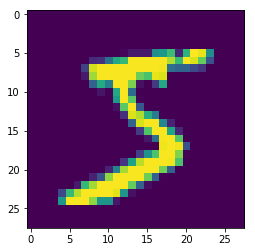

In [6]:
plt.imshow(train_imgs[0].numpy().reshape(28,28))
print(train_labels[0].data)

In [7]:
# scaling 결과 확인
print(np.min(train_imgs.numpy()))
print(np.max(train_imgs.numpy()))

0.0
1.0


In [8]:
a = train_imgs.numpy()

In [9]:
a.shape

(60000, 1, 28, 28)

In [10]:
import torch.utils.data as data_utils

train = data_utils.TensorDataset(train_imgs, train_labels)
train_loader = data_utils.DataLoader(train, batch_size=4, shuffle=False, num_workers=2)

test = data_utils.TensorDataset(test_imgs, test_labels)
test_loader = data_utils.DataLoader(test, batch_size=4, shuffle=False, num_workers=2)

In [11]:
data_iter = iter(train_loader)
imgs, lbs = data_iter.next()

tensor(0, dtype=torch.uint8)


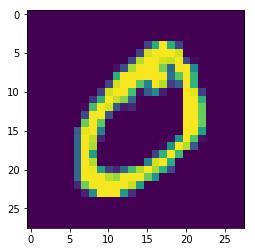

In [12]:
plt.imshow(imgs[1].numpy().reshape(28,28))
print(lbs[1])

---
### define conv NN
---

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1,3,5) # input 1 channel, output 3 channel
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3,6,5) # input 3 channel, output 3 channel
        
        self.fc1 = nn.Linear(6*4*4, 30)
        self.fc2 = nn.Linear(30,10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [15]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=96, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)


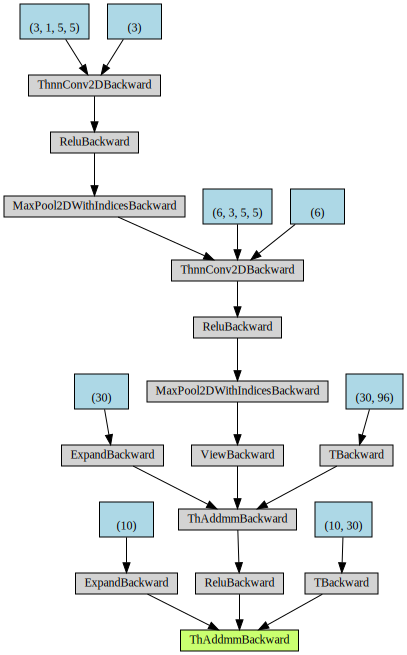

In [32]:
from dot import make_dot

tmp = iter(train_loader)
test_input, _ = tmp.next()

y = net(test_input)
# print(y)
g = make_dot(y)
g

In [27]:
test_input[0].size()

torch.Size([1, 28, 28])

In [18]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9)

In [20]:
t = time.time()

running_loss = 0.0

for epoch in range(2):
    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]
        labels = torch.tensor(labels, dtype = torch.long)
        
        # zero the parametres grads
        opt.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        
        if i % 2000 == 1999: # print every 2000 mini-batchs
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        break
            
elapsed = time.time() - t
print('total elapsed time is {:.2f}s'.format(elapsed))

total elapsed time is 0.05s


In [22]:
outputs.size()

torch.Size([4, 10])

In [24]:
labels

tensor([5, 0, 4, 1])

In [50]:
test_iter = iter(test_loader)
imgs, lbs = test_iter.next()

tensor(7, dtype=torch.uint8)


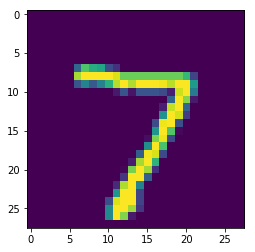

In [51]:
print(lbs[0])
plt.imshow(imgs[0].view(28,28))

In [52]:
outs = net(imgs)
_, preds = torch.max(outs, 1)

print(preds)
print(lbs)

tensor([7, 2, 1, 0])
tensor([7, 2, 1, 0], dtype=torch.uint8)


In [65]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        imgs, lbs = data[0], data[1]
        outs = net(imgs)
        _, predicted = torch.max(outs, 1)
        total += lbs.size(0)
        lbs = torch.tensor(lbs, dtype = torch.long)
        correct += (predicted == lbs).sum().item()
        
print("Accuracy of the network on the 10,000 test images : %d %%" % (100*correct/total))

Accuracy of the network on the 10,000 test images : 92 %


In [66]:
outs.data

tensor([[ -0.8603,   4.3019,   6.1393,  13.1871, -14.1334,   5.6133,  -7.9809,
           2.5757,  -0.3593,  -2.6150],
        [ -6.5445,  -4.7846,  -4.1963,  -2.9850,  10.2259,  -0.3049,  -1.2423,
          -2.8540,   1.9693,   6.6026],
        [  0.2969,  -0.7861,  -2.0839,  -0.7465,  -0.8021,   9.9777,   4.3743,
          -3.7900,   5.5908,  -1.6608],
        [  6.2984,  -7.6445,   4.3119,  -5.6665,   1.3759,   5.5810,  13.4804,
          -9.4841,   1.2216,   0.0110]])

In [67]:
classes = [0,1,2,3,4,5,6,7,8,9]
classes = torch.tensor(classes, dtype = torch.long)
classes

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [97]:
lbs = lbls.long()

In [101]:
lbs.type()

'torch.LongTensor'

In [100]:
preds.type()

'torch.LongTensor'

In [112]:
class_correct = [0. for i in range(10)]
class_total = [0. for i in range(10)]

with torch.no_grad():
    for data in test_loader:
        imgs, lbls = data[0], data[1]
        outs = net(imgs)
        _, preds = torch.max(outs, 1)
        lbls = lbls.long()
        c = (preds == lbls).squeeze() # squeeze -> return to tensor
        
        # batch size
        for i in range(4):
            lb = lbls[i]
            class_correct[lb] += c[i].numpy()
            class_total[lb] += 1
            
for i in range(10):
    print("Accuracy of %3s : %2d %%" % (classes[i].numpy(), 100*class_correct[i]/class_total[i]))

Accuracy of   0 : 98 %
Accuracy of   1 : 98 %
Accuracy of   2 : 92 %
Accuracy of   3 : 91 %
Accuracy of   4 : 86 %
Accuracy of   5 : 93 %
Accuracy of   6 : 93 %
Accuracy of   7 : 82 %
Accuracy of   8 : 90 %
Accuracy of   9 : 94 %


---
### GPU 기반 학습
---

In [34]:
print(torch.cuda.is_available)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

<function is_available at 0x7f7c60c70598>
1
Tesla K80


In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [36]:
net = Net()
net.to(device)
print(net)

criterion = nn.CrossEntropyLoss()
opt = optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9)

Net(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=96, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)


In [40]:
t = time.time()

running_loss = 0.0

for epoch in range(2):
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.long()
        
        # zero the parametres grads
        opt.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        
        if i % 2000 == 1999: # print every 2000 mini-batchs
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
elapsed = time.time() - t
print('total elapsed time is {:.2f}s'.format(elapsed))

[1,  2000] loss: 2.308
[1,  4000] loss: 2.298
[1,  6000] loss: 2.273
[1,  8000] loss: 2.123
[1, 10000] loss: 1.103
[1, 12000] loss: 0.566
[1, 14000] loss: 0.441
[2,  2000] loss: 0.497
[2,  4000] loss: 0.346
[2,  6000] loss: 0.286
[2,  8000] loss: 0.292
[2, 10000] loss: 0.246
[2, 12000] loss: 0.252
[2, 14000] loss: 0.237
total elapsed time is 80.29s


In [41]:
inputs.type

<function Tensor.type>